In [13]:
import gc
import os
import operator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import xgbfir

from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix, hstack

In [18]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}

# Features used in training
categorical_features = ['app', 'device', 'os', 'channel']
numerical_features = [
    'PERCENT_TRUE(clicks.is_attributed)_app_1day',
    'PERCENT_TRUE(clicks.is_attributed)_app_1hour',
    'PERCENT_TRUE(clicks.is_attributed)_app_3hours',
    'PERCENT_TRUE(clicks.is_attributed)_device_1day',
    'PERCENT_TRUE(clicks.is_attributed)_device_1hour',
    'PERCENT_TRUE(clicks.is_attributed)_device_3hours',
    'PERCENT_TRUE(clicks.is_attributed)_os_1day',
    'PERCENT_TRUE(clicks.is_attributed)_os_1hour',
    'PERCENT_TRUE(clicks.is_attributed)_os_3hours',
    'PERCENT_TRUE(clicks.is_attributed)_channel_1day',
    'PERCENT_TRUE(clicks.is_attributed)_channel_1hour',
    'PERCENT_TRUE(clicks.is_attributed)_channel_3hours'
]

train_files = [
    '../data/interim/combined/train_2017-11-08_0000.csv',
    '../data/interim/combined/train_2017-11-08_0100.csv',
    '../data/interim/combined/train_2017-11-08_0200.csv',
    '../data/interim/combined/train_2017-11-08_0300.csv',
    '../data/interim/combined/train_2017-11-08_0400.csv'
]

validation_files = ['../data/interim/combined/train_2017-11-09_0400.csv']

In [15]:
def sparse_dummies(df, column):
    """Returns sparse OHE matrix for the column of the dataframe"""
    categories = Categorical(df[column])
    column_names = np.array([f"{column}_{str(i)}" for i in range(len(categories.categories))])
    N = len(categories)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix((ones, (row_numbers, categories.codes))), column_names

In [16]:
df_train = pd.concat([pd.read_csv(f, dtype=dtypes) for f in train_files], ignore_index=True)
train_size = len(df_train)
print(f"train_size: {train_size}")
l_ = [df_train]
for f in validation_files:
    l_.append(pd.read_csv(f, dtype=dtypes))

df_train = pd.concat(l_, ignore_index=True)

In [17]:
df_train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed',
       'PERCENT_TRUE(clicks.is_attributed)_app_1day',
       'PERCENT_TRUE(clicks.is_attributed)_app_1hour',
       'PERCENT_TRUE(clicks.is_attributed)_app_3hours',
       'PERCENT_TRUE(clicks.is_attributed)_device_1day',
       'PERCENT_TRUE(clicks.is_attributed)_device_1hour',
       'PERCENT_TRUE(clicks.is_attributed)_device_3hours',
       'PERCENT_TRUE(clicks.is_attributed)_os_1day',
       'PERCENT_TRUE(clicks.is_attributed)_os_1hour',
       'PERCENT_TRUE(clicks.is_attributed)_os_3hours',
       'PERCENT_TRUE(clicks.is_attributed)_channel_1day',
       'PERCENT_TRUE(clicks.is_attributed)_channel_1hour',
       'PERCENT_TRUE(clicks.is_attributed)_channel_3hours'],
      dtype='object')

In [20]:
matrices = []
all_column_names = []
# creates a matrix per categorical feature
for c in categorical_features:
    matrix, column_names = sparse_dummies(df_train, c)
    matrices.append(matrix)
    all_column_names.append(column_names)

# appends a matrix for numerical features (one column per feature)
matrices.append(csr_matrix(df_train[numerical_features].values, dtype=float))
all_column_names.append(df_train[numerical_features].columns.values)

train_sparse = hstack(matrices, format="csr")
feature_names = np.concatenate(all_column_names)
del matrices, all_column_names

X = train_sparse
y = df_train['is_attributed']

# del df_train
gc.collect()

4239

In [21]:
# Create binary training and validation files for XGBoost
x1, y1 = X[:train_size], y.iloc[:train_size]
dm1 = xgb.DMatrix(x1, y1, feature_names=feature_names)
dm1.save_binary('../data/cache/train.bin')
del dm1, x1, y1
gc.collect()

x2, y2 = X[train_size:], y.iloc[train_size:]
dm2 = xgb.DMatrix(x2, y2, feature_names=feature_names)
dm2.save_binary('../data/cache/validate.bin')
del dm2, x2, y2, X, y
gc.collect()

41

In [29]:
# XGBoost parameters example
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 10000,  
    'max_depth': 0, 
    'subsample': 0.5, 
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':50,
    'eval_metric': 'auc', 
    'nthread':24,
    'silent': 1
}

In [30]:
# Pointers to binary files for training and validation
# They won't be loaded into Python environment but passed directly to XGBoost
dmtrain = xgb.DMatrix('../data/cache/train.bin', feature_names=feature_names)
dmvalid = xgb.DMatrix('../data/cache/validate.bin', feature_names=feature_names)

# Training process
watchlist = [(dmtrain, 'train'), (dmvalid, 'valid')]
model = xgb.train(params, dmtrain, 50, watchlist, maximize=True, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.961547	valid-auc:0.921128
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.967024	valid-auc:0.954346
[2]	train-auc:0.970853	valid-auc:0.95834
[3]	train-auc:0.972587	valid-auc:0.960584
[4]	train-auc:0.974253	valid-auc:0.961088
[5]	train-auc:0.9761	valid-auc:0.96356
[6]	train-auc:0.977211	valid-auc:0.963922
[7]	train-auc:0.977835	valid-auc:0.963662
[8]	train-auc:0.9783	valid-auc:0.96514
[9]	train-auc:0.978531	valid-auc:0.966684
[10]	train-auc:0.978749	valid-auc:0.966784
[11]	train-auc:0.978924	valid-auc:0.96643
[12]	train-auc:0.978972	valid-auc:0.966232
[13]	train-auc:0.979077	valid-auc:0.96634
[14]	train-auc:0.979155	valid-auc:0.965779
[15]	train-auc:0.979264	valid-auc:0.965372
[16]	train-auc:0.979307	valid-auc:0.96489
[17]	train-auc:0.979343	valid-auc:0.963953
[18]	train-auc:0.979337	valid-auc:0.963469
[19]	train-auc:0.979318	valid-auc:0.963227
[20]	train-auc:0.

In [31]:
# Feature importance as a DataFrame
importance = sorted(model.get_fscore().items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
print(df.sort_values('fscore', ascending=False).head(10))

                                               feature    fscore
619         PERCENT_TRUE(clicks.is_attributed)_os_1day  0.071439
618        PERCENT_TRUE(clicks.is_attributed)_app_1day  0.069937
617   PERCENT_TRUE(clicks.is_attributed)_channel_1hour  0.054579
616        PERCENT_TRUE(clicks.is_attributed)_os_1hour  0.053061
615       PERCENT_TRUE(clicks.is_attributed)_app_1hour  0.048720
614    PERCENT_TRUE(clicks.is_attributed)_channel_1day  0.045341
613       PERCENT_TRUE(clicks.is_attributed)_os_3hours  0.044394
612  PERCENT_TRUE(clicks.is_attributed)_channel_3hours  0.037295
611                                              os_19  0.028350
610                                              os_13  0.028285


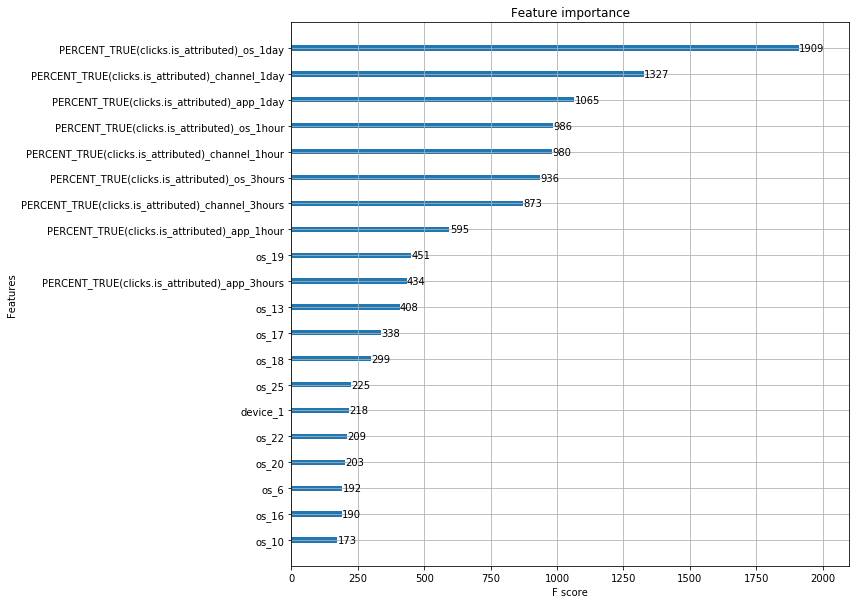

In [28]:
# Feature importance as a plot
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax, max_num_features=20)
plt.savefig('importance.png', format="png")

In [ ]:
xgbfir.saveXgbFI(model)